# Flat Image Net - Evaluate Results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [4]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')

    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
        raw_prediction = tf.nn.dropout(raw_prediction, keep_dropout_prob)
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [5]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_model_eval', graph=graph, remove_existing=True)

## Run Net

In [9]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(10000):
        ##################
        # Training phase #
        ##################
        _images, _labels = data.train.next_batch(100)
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels, keep_dropout_prob: 0.5})
        if iteration % 10 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss],
                                                     feed_dict={images: _images, 
                                                                labels: _labels, 
                                                                keep_dropout_prob: 1.0})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            print("Train Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
      
        ####################
        # Validation phase #
        ####################
        if iteration % 100 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels,
                                                     keep_dropout_prob: 1.0})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images, keep_dropout_prob: 1.0})

Train Iteration 0: loss 2.2878730297088623, accuracy 0.17000000178813934
= Valid Iteration 0: loss 2.296485662460327, accuracy 0.14079999923706055 =
Train Iteration 10: loss 2.133798599243164, accuracy 0.5299999713897705
Train Iteration 20: loss 2.0207221508026123, accuracy 0.6700000166893005
Train Iteration 30: loss 1.9313900470733643, accuracy 0.6800000071525574
Train Iteration 40: loss 1.8878406286239624, accuracy 0.7400000095367432
Train Iteration 50: loss 1.890812873840332, accuracy 0.7400000095367432
Train Iteration 60: loss 1.83711838722229, accuracy 0.7400000095367432
Train Iteration 70: loss 1.8209426403045654, accuracy 0.7799999713897705
Train Iteration 80: loss 1.8195679187774658, accuracy 0.800000011920929
Train Iteration 90: loss 1.8680437803268433, accuracy 0.699999988079071
Train Iteration 100: loss 1.800510287284851, accuracy 0.7400000095367432
= Valid Iteration 100: loss 1.791830062866211, accuracy 0.7631999850273132 =
Train Iteration 110: loss 1.7964216470718384, accu

= Valid Iteration 1100: loss 1.639126181602478, accuracy 0.8392000198364258 =
Train Iteration 1110: loss 1.6283996105194092, accuracy 0.8199999928474426
Train Iteration 1120: loss 1.6844319105148315, accuracy 0.7799999713897705
Train Iteration 1130: loss 1.7267166376113892, accuracy 0.75
Train Iteration 1140: loss 1.6316428184509277, accuracy 0.8600000143051147
Train Iteration 1150: loss 1.6567943096160889, accuracy 0.8399999737739563
Train Iteration 1160: loss 1.6326889991760254, accuracy 0.8399999737739563
Train Iteration 1170: loss 1.6312328577041626, accuracy 0.8299999833106995
Train Iteration 1180: loss 1.6435835361480713, accuracy 0.8399999737739563
Train Iteration 1190: loss 1.5999752283096313, accuracy 0.8999999761581421
Train Iteration 1200: loss 1.6055877208709717, accuracy 0.8799999952316284
= Valid Iteration 1200: loss 1.6313965320587158, accuracy 0.8453999757766724 =
Train Iteration 1210: loss 1.634941577911377, accuracy 0.8399999737739563
Train Iteration 1220: loss 1.6674

Train Iteration 2110: loss 1.6225385665893555, accuracy 0.8600000143051147
Train Iteration 2120: loss 1.6445248126983643, accuracy 0.8299999833106995
Train Iteration 2130: loss 1.6800647974014282, accuracy 0.7900000214576721
Train Iteration 2140: loss 1.5727161169052124, accuracy 0.9100000262260437
Train Iteration 2150: loss 1.6263257265090942, accuracy 0.8500000238418579
Train Iteration 2160: loss 1.5974310636520386, accuracy 0.8799999952316284
Train Iteration 2170: loss 1.6059353351593018, accuracy 0.8600000143051147
Train Iteration 2180: loss 1.6358157396316528, accuracy 0.8299999833106995
Train Iteration 2190: loss 1.6600574254989624, accuracy 0.8100000023841858
Train Iteration 2200: loss 1.6423817873001099, accuracy 0.8299999833106995
= Valid Iteration 2200: loss 1.6169846057891846, accuracy 0.854200005531311 =
Train Iteration 2210: loss 1.6443426609039307, accuracy 0.8100000023841858
Train Iteration 2220: loss 1.6395915746688843, accuracy 0.8100000023841858
Train Iteration 2230: 

Train Iteration 3150: loss 1.6800793409347534, accuracy 0.7699999809265137
Train Iteration 3160: loss 1.5874313116073608, accuracy 0.8999999761581421
Train Iteration 3170: loss 1.6544902324676514, accuracy 0.8100000023841858
Train Iteration 3180: loss 1.6485589742660522, accuracy 0.8199999928474426
Train Iteration 3190: loss 1.6199254989624023, accuracy 0.8399999737739563
Train Iteration 3200: loss 1.6794042587280273, accuracy 0.7799999713897705
= Valid Iteration 3200: loss 1.6011312007904053, accuracy 0.8690000176429749 =
Train Iteration 3210: loss 1.6108295917510986, accuracy 0.8500000238418579
Train Iteration 3220: loss 1.6017276048660278, accuracy 0.8700000047683716
Train Iteration 3230: loss 1.6374151706695557, accuracy 0.8399999737739563
Train Iteration 3240: loss 1.6843771934509277, accuracy 0.7900000214576721
Train Iteration 3250: loss 1.5886224508285522, accuracy 0.8899999856948853
Train Iteration 3260: loss 1.650931715965271, accuracy 0.8100000023841858
Train Iteration 3270: 

Train Iteration 4190: loss 1.6080365180969238, accuracy 0.8600000143051147
Train Iteration 4200: loss 1.5850648880004883, accuracy 0.8700000047683716
= Valid Iteration 4200: loss 1.6050413846969604, accuracy 0.8604000210762024 =
Train Iteration 4210: loss 1.5620436668395996, accuracy 0.9100000262260437
Train Iteration 4220: loss 1.612471580505371, accuracy 0.8600000143051147
Train Iteration 4230: loss 1.6498162746429443, accuracy 0.8100000023841858
Train Iteration 4240: loss 1.5722088813781738, accuracy 0.9200000166893005
Train Iteration 4250: loss 1.585394263267517, accuracy 0.8899999856948853
Train Iteration 4260: loss 1.6056790351867676, accuracy 0.8700000047683716
Train Iteration 4270: loss 1.6170604228973389, accuracy 0.8500000238418579
Train Iteration 4280: loss 1.6052148342132568, accuracy 0.8600000143051147
Train Iteration 4290: loss 1.6056610345840454, accuracy 0.8799999952316284
Train Iteration 4300: loss 1.6180200576782227, accuracy 0.8399999737739563
= Valid Iteration 4300:

Train Iteration 5250: loss 1.6074658632278442, accuracy 0.8600000143051147
Train Iteration 5260: loss 1.5495094060897827, accuracy 0.9300000071525574
Train Iteration 5270: loss 1.5757068395614624, accuracy 0.8999999761581421
Train Iteration 5280: loss 1.5760515928268433, accuracy 0.8899999856948853
Train Iteration 5290: loss 1.6183209419250488, accuracy 0.8600000143051147
Train Iteration 5300: loss 1.5658128261566162, accuracy 0.8899999856948853
= Valid Iteration 5300: loss 1.5944416522979736, accuracy 0.8722000122070312 =
Train Iteration 5310: loss 1.608371615409851, accuracy 0.8700000047683716
Train Iteration 5320: loss 1.6073694229125977, accuracy 0.8600000143051147
Train Iteration 5330: loss 1.5778318643569946, accuracy 0.8999999761581421
Train Iteration 5340: loss 1.5916789770126343, accuracy 0.8899999856948853
Train Iteration 5350: loss 1.586033821105957, accuracy 0.8999999761581421
Train Iteration 5360: loss 1.5805679559707642, accuracy 0.8899999856948853
Train Iteration 5370: l

Train Iteration 6300: loss 1.5807925462722778, accuracy 0.8799999952316284
= Valid Iteration 6300: loss 1.6088215112686157, accuracy 0.8564000129699707 =
Train Iteration 6310: loss 1.6116938591003418, accuracy 0.8600000143051147
Train Iteration 6320: loss 1.589847445487976, accuracy 0.8700000047683716
Train Iteration 6330: loss 1.5892387628555298, accuracy 0.8700000047683716
Train Iteration 6340: loss 1.6395046710968018, accuracy 0.8299999833106995
Train Iteration 6350: loss 1.6170562505722046, accuracy 0.8500000238418579
Train Iteration 6360: loss 1.5896590948104858, accuracy 0.8899999856948853
Train Iteration 6370: loss 1.6209155321121216, accuracy 0.8199999928474426
Train Iteration 6380: loss 1.5160188674926758, accuracy 0.949999988079071
Train Iteration 6390: loss 1.5803097486495972, accuracy 0.8899999856948853
Train Iteration 6400: loss 1.6158599853515625, accuracy 0.8500000238418579
= Valid Iteration 6400: loss 1.603656530380249, accuracy 0.8628000020980835 =
Train Iteration 6410

Train Iteration 7320: loss 1.6111866235733032, accuracy 0.8500000238418579
Train Iteration 7330: loss 1.5451605319976807, accuracy 0.9300000071525574
Train Iteration 7340: loss 1.5622447729110718, accuracy 0.8999999761581421
Train Iteration 7350: loss 1.5462350845336914, accuracy 0.9100000262260437
Train Iteration 7360: loss 1.589994192123413, accuracy 0.8799999952316284
Train Iteration 7370: loss 1.5952426195144653, accuracy 0.8600000143051147
Train Iteration 7380: loss 1.6201287508010864, accuracy 0.8500000238418579
Train Iteration 7390: loss 1.6110070943832397, accuracy 0.8399999737739563
Train Iteration 7400: loss 1.5988571643829346, accuracy 0.8600000143051147
= Valid Iteration 7400: loss 1.596129059791565, accuracy 0.8690000176429749 =
Train Iteration 7410: loss 1.6059367656707764, accuracy 0.8600000143051147
Train Iteration 7420: loss 1.5940479040145874, accuracy 0.8700000047683716
Train Iteration 7430: loss 1.5911309719085693, accuracy 0.8799999952316284
Train Iteration 7440: l

Train Iteration 8350: loss 1.5951037406921387, accuracy 0.8700000047683716
Train Iteration 8360: loss 1.5588067770004272, accuracy 0.8999999761581421
Train Iteration 8370: loss 1.6122496128082275, accuracy 0.8500000238418579
Train Iteration 8380: loss 1.604718804359436, accuracy 0.8700000047683716
Train Iteration 8390: loss 1.594793677330017, accuracy 0.8700000047683716
Train Iteration 8400: loss 1.5851318836212158, accuracy 0.8600000143051147
= Valid Iteration 8400: loss 1.5862840414047241, accuracy 0.878000020980835 =
Train Iteration 8410: loss 1.5819954872131348, accuracy 0.8799999952316284
Train Iteration 8420: loss 1.6001907587051392, accuracy 0.8700000047683716
Train Iteration 8430: loss 1.64180588722229, accuracy 0.8399999737739563
Train Iteration 8440: loss 1.6298867464065552, accuracy 0.8199999928474426
Train Iteration 8450: loss 1.6203384399414062, accuracy 0.8600000143051147
Train Iteration 8460: loss 1.5514614582061768, accuracy 0.9200000166893005
Train Iteration 8470: loss

Train Iteration 9380: loss 1.5657352209091187, accuracy 0.8999999761581421
Train Iteration 9390: loss 1.6141968965530396, accuracy 0.8399999737739563
Train Iteration 9400: loss 1.5568372011184692, accuracy 0.8999999761581421
= Valid Iteration 9400: loss 1.5935001373291016, accuracy 0.8695999979972839 =
Train Iteration 9410: loss 1.6187721490859985, accuracy 0.8500000238418579
Train Iteration 9420: loss 1.554805874824524, accuracy 0.8999999761581421
Train Iteration 9430: loss 1.619608759880066, accuracy 0.8600000143051147
Train Iteration 9440: loss 1.5858817100524902, accuracy 0.8899999856948853
Train Iteration 9450: loss 1.5321741104125977, accuracy 0.9399999976158142
Train Iteration 9460: loss 1.634008765220642, accuracy 0.8299999833106995
Train Iteration 9470: loss 1.5475481748580933, accuracy 0.9200000166893005
Train Iteration 9480: loss 1.6350399255752563, accuracy 0.8199999928474426
Train Iteration 9490: loss 1.5997369289398193, accuracy 0.8799999952316284
Train Iteration 9500: lo

In [10]:
_prediction

array([[  1.14578809e-16,   3.85881377e-17,   8.29091995e-17, ...,
          1.05916309e-09,   2.39715929e-12,   1.00000000e+00],
       [  1.00000000e+00,   3.00616906e-14,   2.62474699e-12, ...,
          1.71658597e-21,   4.45152650e-13,   1.84441329e-12],
       [  9.62565601e-01,   6.78922096e-03,   4.05105855e-03, ...,
          5.33495040e-06,   4.75332808e-06,   3.15550162e-04],
       ..., 
       [  1.42929920e-07,   1.68772896e-09,   5.24524602e-08, ...,
          8.35388128e-05,   7.22596951e-06,   3.37742422e-05],
       [  2.83262249e-08,   2.26425198e-11,   4.11449008e-08, ...,
          4.93750596e-10,   9.99958754e-01,   7.77460832e-13],
       [  2.61036766e-05,   1.46440565e-04,   3.09943607e-05, ...,
          2.67962423e-06,   4.57473179e-05,   3.60576487e-05]], dtype=float32)

## Load reuslts to pandas df

In [11]:
from utils.results_evaluation import get_info_df

df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, images=data.validation.images)
df

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ankle boot,1.000000,Ankle boot,Ankle boot,1.000000,1.000000
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0...",T-shirt/top,1.000000,T-shirt/top,T-shirt/top,1.000000,1.000000
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.962566,T-shirt/top,T-shirt/top,0.962566,0.962566
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",Dress,0.018687,Shirt,Dress,0.531032,0.018687
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.050697,Dress,T-shirt/top,0.901170,0.050697
5,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Pullover,1.000000,Pullover,Pullover,1.000000,1.000000
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,0.999955,Sneaker,Sneaker,0.999955,0.999955
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.003921...",Pullover,0.000849,Coat,Pullover,0.997157,0.000849
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000


In [12]:
df.columns

Index(['image', 'label_class_name', 'label_class_score',
       'predicted_class_name_top1', 'predicted_class_name_top3',
       'predicted_class_score_top1', 'predicted_class_score_top3'],
      dtype='object')

## Recall

In [13]:
def get_recall(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    trues = len(df[(df.label_class_name==class_name)])
    return round(true_positives / trues * 100, 2)

In [14]:
get_recall(df, 'T-shirt/top')

87.53

## Precision

In [15]:
def get_precision(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    positives = len(df[(df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)

In [16]:
get_precision(df, 'T-shirt/top')

75.19

## Accuracy

In [17]:
def get_accuracy(df):
    return round(float(np.mean((df.label_class_name == df.predicted_class_name_top1).astype(int))) * 100, 2)

In [18]:
get_accuracy(df)

87.86

## Overall Recall and Precision

In [19]:
def get_rec_prec(df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [20]:
get_rec_prec(df, class_id2class_name_mapping).sort_values(by='recall')

,class_name,precision,recall
6,Shirt,74.19,60.65
2,Pullover,82.57,75.20
4,Coat,74.95,83.40
0,T-shirt/top,75.19,87.53
3,Dress,90.49,89.22
7,Sneaker,94.17,94.73
9,Ankle boot,95.63,95.06
5,Sandal,96.56,96.75
1,Trouser,98.90,97.12
8,Bag,93.54,97.55


## False Positives

In [21]:
def get_false_positives(df, label_class_name, predicted_class_name=None):
    if predicted_class_name is None:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    else:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']==predicted_class_name)
    return df[condition].sort_values(by='predicted_class_score_top1', ascending=False)

In [22]:
fp = get_false_positives(df, 'Shirt')
fp

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
2012,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Shirt,1.778481e-08,T-shirt/top,Shirt,1.000000,1.778481e-08
3087,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.207843, 0.498...",Shirt,8.331261e-10,T-shirt/top,Shirt,1.000000,8.331261e-10
3946,"[0.0, 0.0, 0.00784314, 0.00392157, 0.00392157,...",Shirt,4.891975e-09,T-shirt/top,Shirt,1.000000,4.891975e-09
523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.220581e-08,T-shirt/top,Shirt,1.000000,1.220581e-08
4031,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,4.088094e-08,T-shirt/top,Shirt,1.000000,4.088094e-08
502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,1.405996e-11,Coat,Pullover,1.000000,1.335097e-10
2987,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0156863, 0.0, 0.32...",Shirt,6.173472e-07,Coat,Shirt,0.999999,6.173472e-07
3298,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,2.450962e-06,T-shirt/top,Shirt,0.999997,2.450962e-06
1388,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.313726, 0.690...",Shirt,4.796929e-06,T-shirt/top,Shirt,0.999995,4.796929e-06
3533,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035...",Shirt,5.065806e-06,T-shirt/top,Shirt,0.999995,5.065806e-06


In [24]:
def plot_examples(df, img_shape=(28, 28)):
    examples_count = min(25, len(df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    
    fig = plt.figure(figsize=(20,25))
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = df.image.iloc[img_id]
        if img is None:
            continue
        img = img.reshape(img_shape)
        prediction_name = df.predicted_class_name_top1.iloc[img_id]
        prediction_score = df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

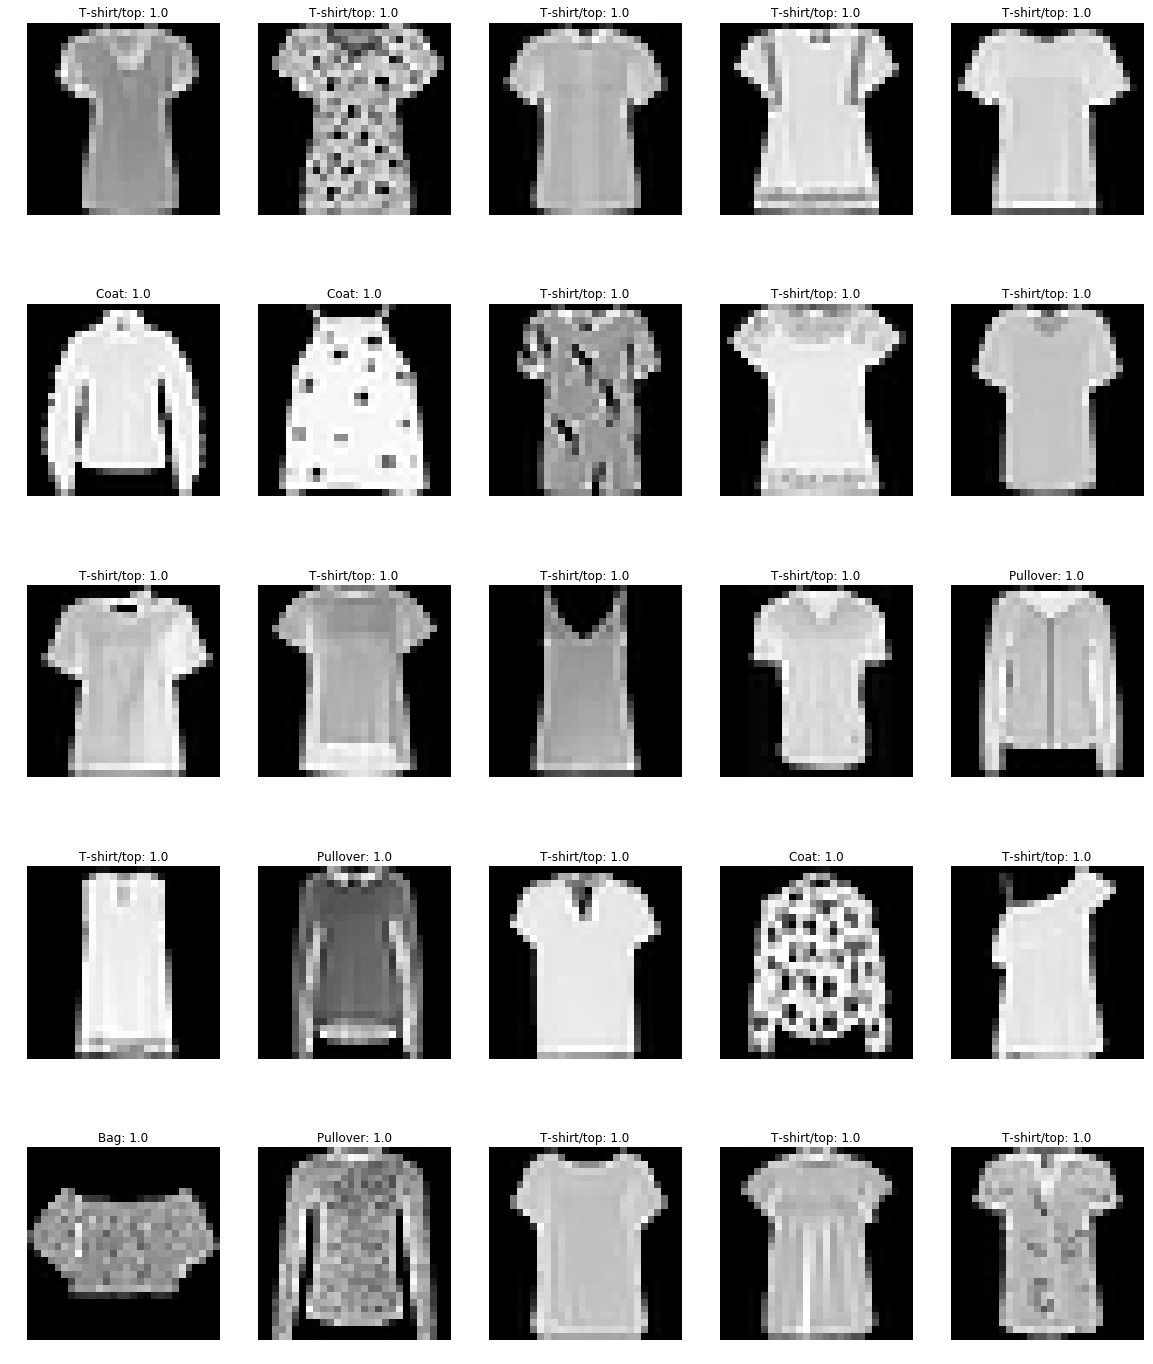

In [25]:
plot_examples(fp)

## Coocurance matrix

In [26]:
def plot_coocurance_matrix(df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        coocurance_df = np.log(coocurance_df)
        coocurance_df = coocurance_df.replace([-np.inf], 0)

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    coocurance_df = coocurance_df.round(2)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")

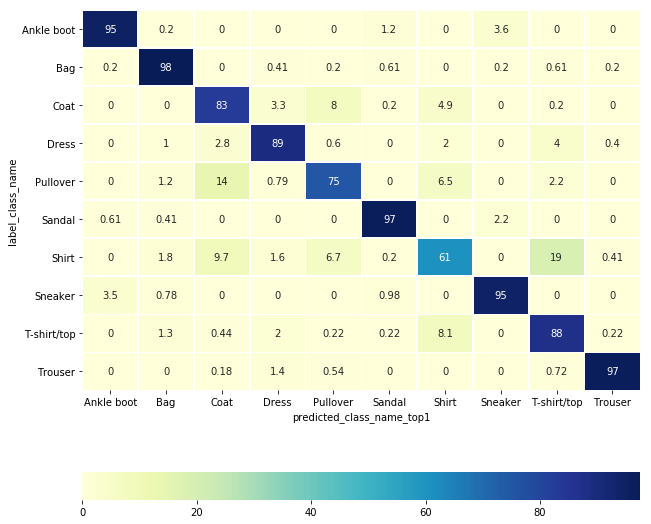

In [27]:
plot_coocurance_matrix(df, use_log=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


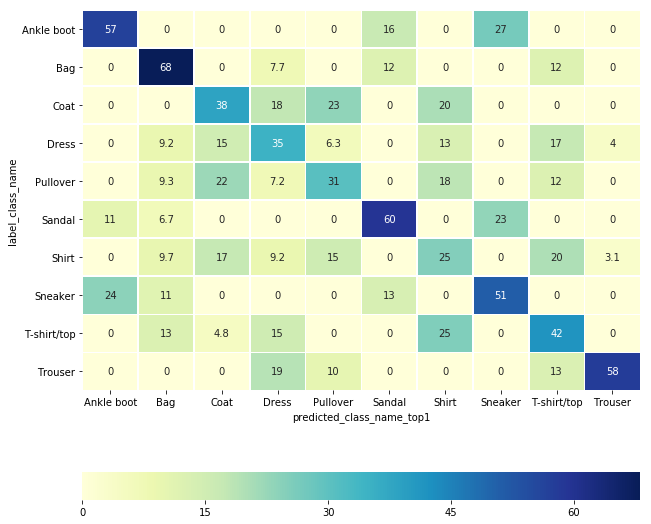

In [28]:
plot_coocurance_matrix(df, use_log=True)